In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

/tmp/ipykernel_18552/956813560.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
#chack for updated files\n,
%load_ext autoreload
%autoreload 2
#import packages
from __future__ import division

%load_ext line_profiler
import numpy as np
import glob, json
import pickle
import os as os_pack
import matplotlib.pyplot as plt
import corner
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import healpy as hp
import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl
import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const
from enterprise_extensions import blocks
from enterprise_extensions import models as ee_models
from enterprise_extensions import model_utils as ee_model_utils
from enterprise_extensions import model_orfs
from enterprise_extensions.frequentist import optimal_statistic as opt_stat
from enterprise_extensions import sampler as ee_sampler
from enterprise.signals.signal_base import LogLikelihood
import enterprise_wavelets as models
from enterprise.signals.deterministic_signals import Deterministic
from enterprise.signals.parameter import function
from la_forge.core import Core
from la_forge.diagnostics import plot_chains
from la_forge import rednoise
import la_forge
import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import re
#style
    
#import Fast_Burst_likelihood as FB

In [3]:
def figsize(scale):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [2 * fig_width,2 * fig_height]       #1* scaling factor for 2 collem paper
    return fig_size
plt.rcParams.update(plt.rcParamsDefault)

params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        #'font.serif':'Times',
        #'text.latex.preamble': [r'\usepackage{amsmath}'],
        #'text.usetex':True,
        'figure.figsize': figsize(0.5)}
#plt.style.use('dark_background')
plt.style.use('default')
plt.rcParams.update(params)

In [4]:
#Loading in pickle and noise files
pint_pickle = '/home/reyna/OS_15yr/15yr_data/v1p1_de440_pint_bipm2019.pkl'
noise_file = '/home/reyna/OS_15yr/15yr_data/v1p1_wn_dict.json'
#psrlist = np.loadtxt('/home/reyna/15yr_v1p0/15yr_v1-20211001T235643Z-001/15yr_v1/psrlist_15yr_pint.txt', dtype = str)
with open(noise_file, 'r') as h:
    noise_params = json.load(h)
with open(pint_pickle,'rb') as f:
    allpsrs = pickle.load(f)
psrs = []
for ii,p in enumerate(allpsrs):
    psrs.append(p)
#Temporary to get code to not crash
psrs = psrs[0:]
psrlist = [psr.name for psr in psrs]
print(psrlist)
for i in range(len(psrs)):
    print((max(psrs[i].toas) - min(psrs[i].toas))/(3.17*10**(7)))

['B1855+09', 'B1937+21', 'B1953+29', 'J0023+0923', 'J0030+0451', 'J0340+4130', 'J0406+3039', 'J0437-4715', 'J0509+0856', 'J0557+1551', 'J0605+3757', 'J0610-2100', 'J0613-0200', 'J0636+5128', 'J0645+5158', 'J0709+0458', 'J0740+6620', 'J0931-1902', 'J1012+5307', 'J1012-4235', 'J1022+1001', 'J1024-0719', 'J1125+7819', 'J1312+0051', 'J1453+1902', 'J1455-3330', 'J1600-3053', 'J1614-2230', 'J1630+3734', 'J1640+2224', 'J1643-1224', 'J1705-1903', 'J1713+0747', 'J1719-1438', 'J1730-2304', 'J1738+0333', 'J1741+1351', 'J1744-1134', 'J1745+1017', 'J1747-4036', 'J1751-2857', 'J1802-2124', 'J1811-2405', 'J1832-0836', 'J1843-1113', 'J1853+1303', 'J1903+0327', 'J1909-3744', 'J1910+1256', 'J1911+1347', 'J1918-0642', 'J1923+2515', 'J1944+0907', 'J1946+3417', 'J2010-1323', 'J2017+0603', 'J2033+1734', 'J2043+1711', 'J2124-3358', 'J2145-0750', 'J2214+3000', 'J2229+2643', 'J2234+0611', 'J2234+0944', 'J2302+4442', 'J2317+1439', 'J2322+2057']
15.515060297068947
15.802872967471835
11.08458774068679
8.975425297

In [5]:
glitches = []
N_glitches = 5
for i in range(N_glitches):
    log10_f0 = parameter.Uniform(np.log10(3.5e-9), np.log10(1e-7))("Glitch_"+str(i)+'_'+'log10_f0')
    phase0 = parameter.Uniform(0, 2*np.pi)("Glitch_"+str(i)+'_'+'phase0')
    tau = parameter.Uniform(0.2, 5)("Glitch_"+str(i)+'_'+'tau')
    t0 = parameter.Uniform(0.0, 10.0)("Glitch_"+str(i)+'_'+'t0')
    psr_idx = parameter.Uniform(-0.5, len(psrs)-0.5)("Glitch_"+str(i)+'_'+'psr_idx')
    log10_h = parameter.LinearExp(-10.5, -9)("Glitch_"+str(i)+'_'+'log10_h')
    glitch_wf = models.glitch_delay(log10_h = log10_h, tau = tau, log10_f0 = log10_f0, t0 = t0, phase0 = phase0, tref=53000*86400,
                                            psr_float_idx = psr_idx, pulsars=psrs)
    glitches.append(deterministic_signals.Deterministic(glitch_wf, name='Glitch'+str(i) ))

In [6]:
#wavelet models
wavelets = [] #added "wavelet_" to names to help with seperation
N_wavelets = 5
for i in range(N_wavelets):
    log10_f0 = parameter.Uniform(np.log10(3.5e-9), np.log10(1e-7))("wavelet_"+str(i)+'_'+'log10_f0')
    cos_gwtheta = parameter.Uniform(-1, 1)("wavelet_"+str(i)+'_'+'cos_gwtheta')
    gwphi = parameter.Uniform(0, 2*np.pi)("wavelet_"+str(i)+'_'+'gwphi')
    psi = parameter.Uniform(0, np.pi)("wavelet_"+str(i)+'_'+'gw_psi')
    phase0 = parameter.Uniform(0, 2*np.pi)("wavelet_"+str(i)+'_'+'phase0')
    phase0_cross = parameter.Uniform(0, 2*np.pi)("wavelet_"+str(i)+'_'+'phase0_cross')
    tau = parameter.Uniform(0.2, 5)("wavelet_"+str(i)+'_'+'tau')
    t0 = parameter.Uniform(0.0, 10.0)("wavelet_"+str(i)+'_'+'t0')
    log10_h = parameter.LinearExp(-18,-11)("wavelet_"+str(i)+'_'+'log10_h')
    log10_h_cross = parameter.LinearExp(-18,-11)("wavelet_"+str(i)+'_'+'log10_h_cross')
    wavelet_wf = models.wavelet_delay(cos_gwtheta=cos_gwtheta, gwphi=gwphi, log10_h = log10_h, log10_h2=log10_h_cross,
                                      tau = tau, log10_f0 = log10_f0, t0 = t0, phase0 = phase0, phase02=phase0_cross,
                                      epsilon = None, psi=psi, tref=53000*86400)
    wavelets.append(deterministic_signals.Deterministic(wavelet_wf, name='wavelet'+str(i)))

In [7]:
tm = gp_signals.TimingModel(use_svd=True)
wn = blocks.white_noise_block(vary=False, inc_ecorr=False)

Tspan = ee_model_utils.get_tspan(psrs)
rn = blocks.red_noise_block(psd='powerlaw', prior = 'log-uniform', Tspan=Tspan, components = 30)

fgamma = 13./3.
vary_gamma = parameter.Uniform(0,7)('gw_gamma')
log10_A = parameter.Uniform(-18,-11)('gw_log10_A')
com_comp = 14  
pl = utils.powerlaw(log10_A=log10_A, gamma = vary_gamma)
crn = gp_signals.FourierBasisGP(spectrum=pl, components = com_comp, Tspan=Tspan, name='gw')

#s = base_model
s = tm + wn #+ crn + rn
for i in range(N_glitches):
    s += glitches[i]
for j in range(N_wavelets):
    s += wavelets[j]
model = []
for p in psrs:
    model.append(s(p))
with open(noise_file, 'r') as fp:
    noisedict = json.load(fp)
    pta = signal_base.PTA(model)
    pta.set_default_params(noisedict)

In [8]:
d0_15y = parameter.sample(pta.params)
x0_15y = np.array([d0_15y[par.name] for par in pta.params])

In [23]:
pta.params

[Glitch_0_log10_f0:Uniform(pmin=-8.455931955649724, pmax=-7.0),
 Glitch_0_log10_h:LinearExp(pmin=-10.5, pmax=-9),
 Glitch_0_phase0:Uniform(pmin=0, pmax=6.283185307179586),
 Glitch_0_psr_idx:Uniform(pmin=-0.5, pmax=66.5),
 Glitch_0_t0:Uniform(pmin=0.0, pmax=10.0),
 Glitch_0_tau:Uniform(pmin=0.2, pmax=5),
 Glitch_1_log10_f0:Uniform(pmin=-8.455931955649724, pmax=-7.0),
 Glitch_1_log10_h:LinearExp(pmin=-10.5, pmax=-9),
 Glitch_1_phase0:Uniform(pmin=0, pmax=6.283185307179586),
 Glitch_1_psr_idx:Uniform(pmin=-0.5, pmax=66.5),
 Glitch_1_t0:Uniform(pmin=0.0, pmax=10.0),
 Glitch_1_tau:Uniform(pmin=0.2, pmax=5),
 Glitch_2_log10_f0:Uniform(pmin=-8.455931955649724, pmax=-7.0),
 Glitch_2_log10_h:LinearExp(pmin=-10.5, pmax=-9),
 Glitch_2_phase0:Uniform(pmin=0, pmax=6.283185307179586),
 Glitch_2_psr_idx:Uniform(pmin=-0.5, pmax=66.5),
 Glitch_2_t0:Uniform(pmin=0.0, pmax=10.0),
 Glitch_2_tau:Uniform(pmin=0.2, pmax=5),
 Glitch_3_log10_f0:Uniform(pmin=-8.455931955649724, pmax=-7.0),
 Glitch_3_log10_h:Lin

In [10]:
d0_15y_2 = parameter.sample(pta.params)

In [11]:
for n in range(N_glitches):
    d0_15y_2['Glitch_'+str(n)+'_log10_f0'] = d0_15y['Glitch_'+str(n)+'_log10_f0']
    d0_15y_2['Glitch_'+str(n)+'_psr_idx'] = d0_15y['Glitch_'+str(n)+'_psr_idx']
    d0_15y_2['Glitch_'+str(n)+'_t0'] = d0_15y['Glitch_'+str(n)+'_t0']
    d0_15y_2['Glitch_'+str(n)+'_tau'] = d0_15y['Glitch_'+str(n)+'_tau']
for w in range(N_wavelets):
    d0_15y_2['wavelet_'+str(w)+'_log10_f0'] = d0_15y['wavelet_'+str(w)+'_log10_f0']
    d0_15y_2['wavelet_'+str(w)+'_t0'] = d0_15y['wavelet_'+str(w)+'_t0']
    d0_15y_2['wavelet_'+str(w)+'_tau'] = d0_15y['wavelet_'+str(w)+'_tau']

In [12]:
x0_15y_2 = np.array([d0_15y_2[par.name] for par in pta.params])

In [88]:
%lprun -f pta.get_lnlikelihood pta.get_lnlikelihood(x0_15y)

In [94]:
%lprun -f pta.get_lnlikelihood pta.get_lnlikelihood(x0_15y_2)

In [98]:
import Fast_Burst_likelihood as FB

In [96]:
rn = False
FB_15y = FB.FastBurst(pta = pta, psrs = psrs, params = d0_15y, Npsr = len(psrs), tref=53000*86400, Nglitch = N_glitches, Nwavelet = N_wavelets, rn_vary = rn)

In [97]:
%lprun -f FB_15y.get_lnlikelihood FB_15y.get_lnlikelihood(x0_15y)

In [56]:
%timeit FB_15y.get_lnlikelihood(x0_15y_2)

63.4 µs ± 1.08 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [57]:
%lprun -f FB_15y.get_lnlikelihood FB_15y.get_lnlikelihood(x0_15y_2)

In [72]:
NN = 20

log_L_Ent_15y = []
log_L_Fast_15y = []
#amplitudes = []

for n in range(NN):
    #amplitudes.append(i*0.5e-6)
    d0_15y = parameter.sample(pta.params)
    x0_15y = np.array([d0_15y[par.name] for par in pta.params])
    
    log_L_Ent_15y.append(pta.get_lnlikelihood(x0_15y))
    log_L_Fast_15y.append(FB_15y.get_lnlikelihood(x0_15y))
    print('run ',n)

run  0
run  1
run  2
run  3
run  4
run  5
run  6
run  7
run  8
run  9
run  10
run  11
run  12
run  13
run  14
run  15
run  16
run  17
run  18
run  19


In [73]:
log_L_Ent_15y = np.array(log_L_Ent_15y)
log_L_Fast_15y = np.array(log_L_Fast_15y)

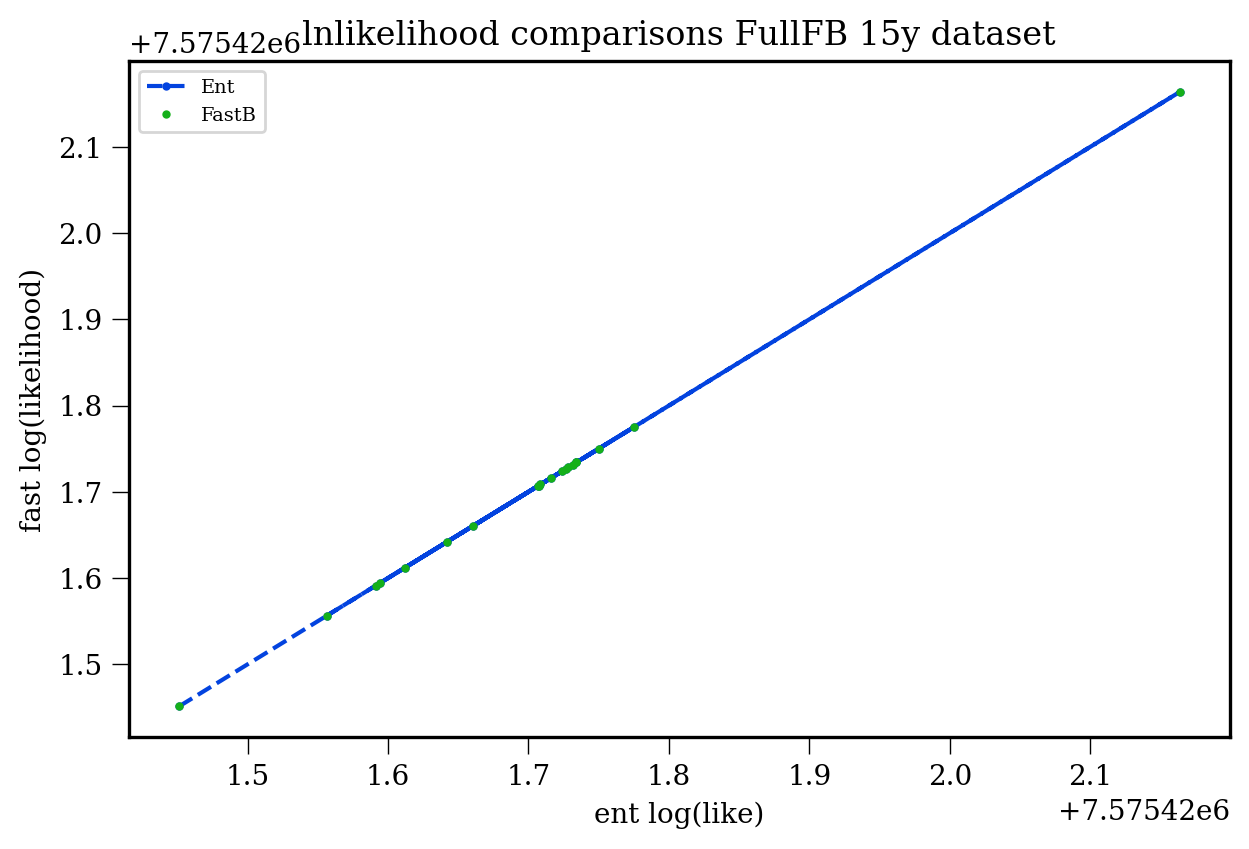

In [74]:
plt.figure()
plt.plot(log_L_Ent_15y, log_L_Ent_15y, ls='--', marker='.', color='xkcd:blue', label = 'Ent')
plt.plot(log_L_Ent_15y, log_L_Fast_15y, ls='', marker='.', color='xkcd:green', label = 'FastB')
plt.legend(loc='upper left')
plt.xlabel("ent log(like)")
plt.ylabel("fast log(likelihood)")
plt.title('lnlikelihood comparisons FullFB 15y dataset')
#plt.savefig('/home/reyna/BayesHopperBurst/testing plots/FullFastBurst_15y_lnlikedif.pdf')
plt.show()

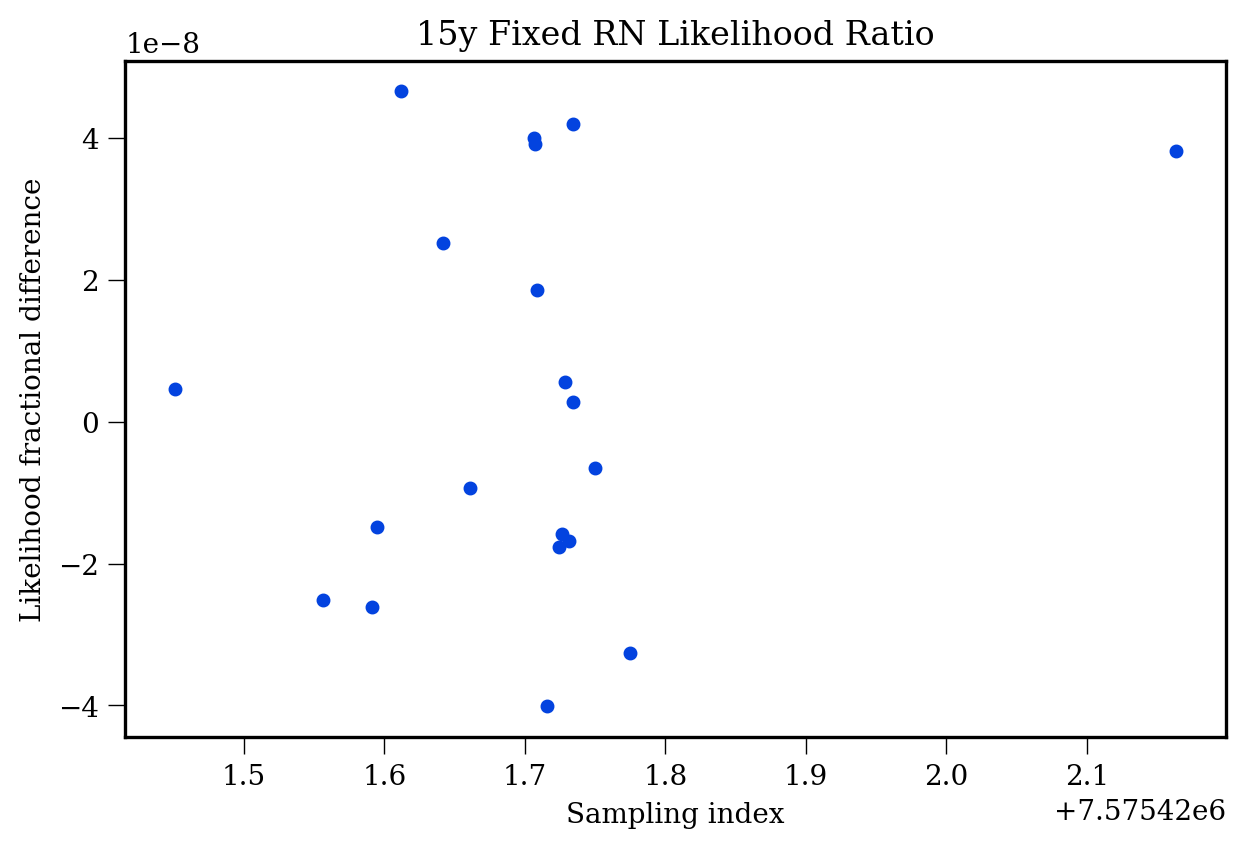

In [75]:
plt.plot(log_L_Fast_15y,np.exp(log_L_Fast_15y - log_L_Ent_15y)-1, ls='', marker='o', color='xkcd:blue')
#plt.hlines(y = 0, xmin = 0, xmax = 50, ls = '--', color = 'black')
#plt.gca().axhline(0.1, ls='--', color='xkcd:green')
plt.xlabel("Sampling index")
#plt.xscale('log')
plt.ylabel("Likelihood fractional difference")
plt.title('15y Fixed RN Likelihood Ratio')
#plt.savefig('/home/reyna/BayesHopperBurst/testing plots/15y_like_dif_RN_fixed.pdf', transparent=True)
plt.show()

In [217]:
np.exp(log_L_Fast_15y - log_L_Ent_15y)-1

array([-5.88597171e-05, -3.14757294e-02,  3.15960719e-03, -3.74510587e-04,
        2.56172584e-03,  1.86877361e+00,  3.95107463e-03, -4.82185972e-01,
        1.63424143e-04,  2.62747881e-03,  1.26856640e+00,  4.61364136e-01,
        4.52718456e-02, -6.91764698e-01, -1.30117558e-02, -3.66185919e-03,
       -8.66731390e-03, -5.17505579e-01,  2.01258531e-02, -1.24064745e-02])

In [218]:
log_L_Fast_15y

array([7957928.81077643, 7956298.51421408, 7956914.35981946,
       7939994.60790684, 7957902.0161521 , 7892979.39598267,
       7950904.11544481, 7955141.1117899 , 7937419.91981984,
       7954647.08090582, 7867712.38403108, 7958372.75330197,
       7958489.19622281, 7575634.73628175, 7958941.25543993,
       7956775.86110597, 7952457.30782962, 7575456.35610329,
       7939127.5419339 , 7958435.94640814])

In [121]:
FB_15y = FB.FastBurst(pta = pta, psrs = psrs, params = d0_15y, Npsr = len(psrs), tref=53000*86400, Nglitch = N_glitches, Nwavelet = N_wavelets)

In [176]:
#%%prun
NN = 30

log_L_Ent_15y_shaped = []
log_L_Fast_15y_shaped = []

for s in range(NN):
    d0_15y_2 = parameter.sample(pta.params)
    for n in range(N_glitches):
        d0_15y_2['Glitch_'+str(n)+'_log10_f0'] = d0_15y['Glitch_'+str(n)+'_log10_f0']
        d0_15y_2['Glitch_'+str(n)+'_psr_idx'] = d0_15y['Glitch_'+str(n)+'_psr_idx']
        d0_15y_2['Glitch_'+str(n)+'_t0'] = d0_15y['Glitch_'+str(n)+'_t0']
        d0_15y_2['Glitch_'+str(n)+'_tau'] = d0_15y['Glitch_'+str(n)+'_tau']
    for w in range(N_wavelets):
        d0_15y_2['wavelet_'+str(w)+'_log10_f0'] = d0_15y['wavelet_'+str(w)+'_log10_f0']
        d0_15y_2['wavelet_'+str(w)+'_t0'] = d0_15y['wavelet_'+str(w)+'_t0']
        d0_15y_2['wavelet_'+str(w)+'_tau'] = d0_15y['wavelet_'+str(w)+'_tau']
    x0_15y_2 = np.array([d0_15y_2[par.name] for par in pta.params])

    log_L_Ent_15y_shaped.append(pta.get_lnlikelihood(x0_15y_2))
    log_L_Fast_15y_shaped.append(FB_15y.get_lnlikelihood(x0_15y_2))
    print('run ',s)
    
log_L_Ent_15y_shaped = np.array(log_L_Ent_15y_shaped)
log_L_Fast_15y_shaped = np.array(log_L_Fast_15y_shaped)

run  0
run  1
run  2
run  3
run  4
run  5
run  6
run  7
run  8
run  9
run  10
run  11
run  12
run  13
run  14
run  15
run  16
run  17
run  18
run  19
run  20
run  21
run  22
run  23
run  24
run  25
run  26
run  27
run  28
run  29


Text(0.5, 1.0, 'lnlikelihood comparisons FullFB 15y dataset')

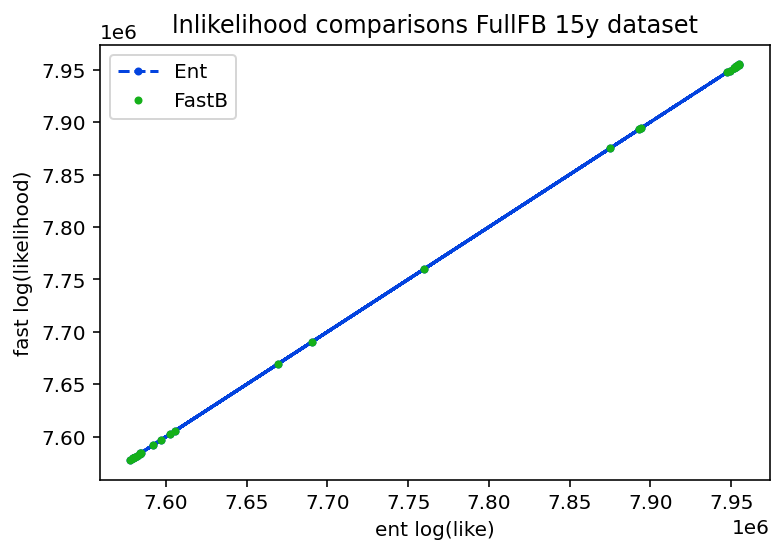

In [177]:
plt.plot(log_L_Ent_15y_shaped, log_L_Ent_15y_shaped, ls='--', marker='.', color='xkcd:blue', label = 'Ent')
plt.plot(log_L_Ent_15y_shaped, log_L_Fast_15y_shaped, ls='', marker='.', color='xkcd:green', label = 'FastB')
plt.legend(loc='upper left')
plt.xlabel("ent log(like)")
plt.ylabel("fast log(likelihood)")
plt.title('lnlikelihood comparisons FullFB 15y dataset')
#plt.savefig('/home/reyna/BayesHopperBurst/testing plots/FullFastBurst_15y_lnlikedif.png')

In [27]:
plt.plot(np.exp(log_L_Fast_15y_shaped - log_L_Ent_15y_shaped), ls='', marker='.', color='xkcd:blue')
#plt.gca().axhline(0.1, ls='--', color='xkcd:green')
plt.xlabel("index")
plt.ylabel("delta log(likelihood)")
plt.title('val dif for randome samples 15y')
#plt.savefig('/home/reyna/BayesHopperBurst/testing plots/FullFastBurst_15y_precentdif.png')
plt.show()

NameError: name 'log_L_Fast_15y_shaped' is not defined

In [33]:
import QuickBurst_MCMC
N=int(2)

T_max = 2 #8
n_chain = 2 #10

#ts_file = "/home/reyna/BayesHopperBurst/BenceData/with_burst/tauscan_12p5yr-like_real4_RN.pkl"
#glitch_ts_file = "/home/reyna/BayesHopperBurst/BenceData/with_burst/glitch_tauscan_12p5yr-like_real4_RN.pkl.pkl"

#noisedict_file = "/home/reyna/BayesHopperBurst/BenceData/with_burst/params_simulated.json"
#RN_start_file = "../12p5yr-like_data/RN_start_values.npz"

savefile = "/home/reyna/BayesHopperBurst/QuickBurst/Testing/chain_test1.npz" #only saving a chain

samples, acc_fraction, swap_record, rj_record, ptas, log_likelihood, betas, PT_acc = QuickBurst_MCMC.run_bhb(N, T_max, n_chain, psrs,
                                                                    max_n_wavelet=5,
                                                                    min_n_wavelet=0,
                                                                    n_wavelet_start=3,
                                                                    RJ_weight=0,
                                                                    glitch_RJ_weight=0,
                                                                    regular_weight=4,
                                                                    noise_jump_weight=0,
                                                                    PT_swap_weight=1,
                                                                    tau_scan_proposal_weight=0,
                                                                    glitch_tau_scan_proposal_weight=0,
                                                                    gwb_switch_weight=0,
                                                                    #tau_scan_file=ts_file,
                                                                    #glitch_tau_scan_file=glitch_ts_file,
                                                                    #gwb_log_amp_range=[-18,-15],
                                                                    rn_log_amp_range=[-18,-15],
                                                                    wavelet_log_amp_range=[-10.0,-5],
                                                                    per_psr_rn_log_amp_range=[-18,-15],
                                                                    prior_recovery=False,
                                                                    #gwb_amp_prior='log-uniform',
                                                                    rn_amp_prior='log-uniform',
                                                                    wavelet_amp_prior='uniform',
                                                                    per_psr_rn_amp_prior='log-uniform',
                                                                    #gwb_on_prior=0.975,
                                                                    max_n_glitch=5,
                                                                    n_glitch_start=1,
                                                                    glitch_log_amp_range=[-10.0,-5],
                                                                    glitch_amp_prior='uniform',
                                                                    t0_max=10,
                                                                    draw_from_prior_weight=0, de_weight=0,
                                                                    vary_white_noise=True,
                                                                    include_gwb=False,
                                                                    include_rn=False, vary_rn=False,
                                                                    include_equad_ecorr=False,
                                                                    wn_backend_selection=False,
                                                                    noisedict_file=noise_file,
                                                                    include_per_psr_rn=False,
                                                                    vary_per_psr_rn=False,
                                                                    #resume_from=None,
                                                                    #per_psr_rn_start_file=RN_start_file,
                                                                    savefile=savefile, save_every_n=1)

np.savez(savefile, samples=samples, acc_fraction=acc_fraction, swap_record=swap_record, log_likelihood=log_likelihood)

[B1855+09_efac:Uniform(pmin=0.01, pmax=10.0), B1937+21_efac:Uniform(pmin=0.01, pmax=10.0), B1953+29_efac:Uniform(pmin=0.01, pmax=10.0), Glitch_0_log10_f0:Uniform(pmin=-8.455931955649724, pmax=-7.0), Glitch_0_log10_h:LinearExp(pmin=-10.0, pmax=-5), Glitch_0_phase0:Uniform(pmin=0, pmax=6.283185307179586), Glitch_0_psr_idx:Uniform(pmin=-0.5, pmax=66.5), Glitch_0_t0:Uniform(pmin=0.0, pmax=10), Glitch_0_tau:Uniform(pmin=0.2, pmax=5), Glitch_1_log10_f0:Uniform(pmin=-8.455931955649724, pmax=-7.0), Glitch_1_log10_h:LinearExp(pmin=-10.0, pmax=-5), Glitch_1_phase0:Uniform(pmin=0, pmax=6.283185307179586), Glitch_1_psr_idx:Uniform(pmin=-0.5, pmax=66.5), Glitch_1_t0:Uniform(pmin=0.0, pmax=10), Glitch_1_tau:Uniform(pmin=0.2, pmax=5), Glitch_2_log10_f0:Uniform(pmin=-8.455931955649724, pmax=-7.0), Glitch_2_log10_h:LinearExp(pmin=-10.0, pmax=-5), Glitch_2_phase0:Uniform(pmin=0, pmax=6.283185307179586), Glitch_2_psr_idx:Uniform(pmin=-0.5, pmax=66.5), Glitch_2_t0:Uniform(pmin=0.0, pmax=10), Glitch_2_tau:

[ 9.78112460e+00  9.37450770e+00  9.23515260e+00  3.30921719e+00
  7.65815677e+00  8.73980337e+00  6.58359000e+00  2.52579491e-01
  6.68238970e+00  7.24791131e+00  9.78112460e+00  9.37450770e+00
  9.23515260e+00  7.25840786e+00  6.30880689e+00  9.05795398e+00
  9.03344862e+00  6.93330967e+00  8.91435984e+00  3.97382211e+00
  9.78112460e+00  9.37450770e+00  9.23515260e+00  7.61340771e+00
  6.32728422e+00  7.61128264e+00  3.73929299e+00  2.89041693e+00
  1.99236366e+00  5.32951624e+00  4.03936508e+00  3.92840119e+00
  6.72624016e+00 -8.32119536e+00 -5.28647630e+00  2.57083696e+00
  3.91175497e-01  3.52609426e+00  4.56424573e+00  8.40657971e-01
  7.31880823e+00  7.18030364e+00  6.08022727e+00  4.69923700e+00
  9.55659583e+00  3.14493160e+00  1.01567124e+00  2.13737837e+00
  8.05075089e+00  8.08350557e+00  5.36762603e+00  9.92986566e+00
  8.39829607e+00  8.42838647e+00  3.81169440e+00  1.69286705e+00
  4.84416096e+00  5.57389630e+00  8.07322830e+00  4.64168087e+00
  9.71237335e+00  7.18872

In [32]:
%lprun -f QuickBurst_MCMC.run_bhb QuickBurst_MCMC.run_bhb(N, T_max, n_chain, psrs,max_n_wavelet=5,min_n_wavelet=0,n_wavelet_start=3,RJ_weight=0,glitch_RJ_weight=0,regular_weight=4,noise_jump_weight=0,PT_swap_weight=1,tau_scan_proposal_weight=0,glitch_tau_scan_proposal_weight=0,gwb_switch_weight=0,rn_log_amp_range=[-18,-15],wavelet_log_amp_range=[-10.0,-5],per_psr_rn_log_amp_range=[-18,-15],prior_recovery=False,rn_amp_prior='log-uniform',wavelet_amp_prior='uniform',per_psr_rn_amp_prior='log-uniform',max_n_glitch=5,n_glitch_start=1,glitch_log_amp_range=[-10.0,-5],glitch_amp_prior='uniform',t0_max=10,draw_from_prior_weight=0, de_weight=0,vary_white_noise=True,include_gwb=False,include_rn=False, vary_rn=False,include_equad_ecorr=False,wn_backend_selection=False,noisedict_file=noise_file,include_per_psr_rn=False,vary_per_psr_rn=False,savefile=savefile, save_every_n=1)

[B1855+09_efac:Uniform(pmin=0.01, pmax=10.0), B1937+21_efac:Uniform(pmin=0.01, pmax=10.0), B1953+29_efac:Uniform(pmin=0.01, pmax=10.0), Glitch_0_log10_f0:Uniform(pmin=-8.455931955649724, pmax=-7.0), Glitch_0_log10_h:LinearExp(pmin=-10.0, pmax=-5), Glitch_0_phase0:Uniform(pmin=0, pmax=6.283185307179586), Glitch_0_psr_idx:Uniform(pmin=-0.5, pmax=66.5), Glitch_0_t0:Uniform(pmin=0.0, pmax=10), Glitch_0_tau:Uniform(pmin=0.2, pmax=5), Glitch_1_log10_f0:Uniform(pmin=-8.455931955649724, pmax=-7.0), Glitch_1_log10_h:LinearExp(pmin=-10.0, pmax=-5), Glitch_1_phase0:Uniform(pmin=0, pmax=6.283185307179586), Glitch_1_psr_idx:Uniform(pmin=-0.5, pmax=66.5), Glitch_1_t0:Uniform(pmin=0.0, pmax=10), Glitch_1_tau:Uniform(pmin=0.2, pmax=5), Glitch_2_log10_f0:Uniform(pmin=-8.455931955649724, pmax=-7.0), Glitch_2_log10_h:LinearExp(pmin=-10.0, pmax=-5), Glitch_2_phase0:Uniform(pmin=0, pmax=6.283185307179586), Glitch_2_psr_idx:Uniform(pmin=-0.5, pmax=66.5), Glitch_2_t0:Uniform(pmin=0.0, pmax=10), Glitch_2_tau:

/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:228: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:232: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:238: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


[ 7.30966907  3.52739299  8.95219465  1.49061349  0.87185084  8.42098274
  6.87624939  2.72930881  8.09502453  5.0857903   7.30966907  3.52739299
  8.95219465  6.11078779  8.24888352  0.4870795   6.01364956  3.55218776
  3.52899706  0.43371652  7.30966907  3.52739299  8.95219465  9.06014237
  8.93170983  0.2888962   5.36096883  5.50793593  3.36599657  7.32046074
  7.39059038  5.95692204  6.82599923 -7.38765268 -5.06520181  0.36175377
  1.23886293  3.69108727  5.75804145  5.69695731  0.44574608  1.1840997
  9.8109341   1.56430923  4.06674314  4.45349376  3.13348117  6.95255484
  4.77736684  4.3467835   8.21480659  9.20413006  2.5422202   9.85792363
  5.92210019  4.84724881  8.60781067  4.11974306  9.56068146  9.14378543
  2.78016007  1.34163733  0.29108701  5.95007401  7.94993693  8.60539058
  1.26442703  3.46048887  5.62329232  1.11657654  4.72366114  4.68365579
  7.31708281 -0.29576483  1.42721063  2.59215185 -7.86123235 -5.07846731
 -5.32359754  5.01472074  0.8484443   4.89602097  3.

/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:291: ComplexWarning: Casting complex values to real discards the imaginary part


Changed some nan elements in the Fisher matrix to 1.0
Percentage of steps doing different jumps:
PT swaps: 20.00%
RJ moves: 0.00%
Glitch RJ moves: 0.00%
GWB-switches: 0.00%
Tau-scan-proposals: 0.00%
Glitch tau-scan-proposals: 0.00%
Jumps along Fisher eigendirections: 80.00%
Noise jump: 0.00%
Progress: 0.00% Acceptance fraction #columns: chain number; rows: proposal type (glitch_RJ, glitch_tauscan, wavelet_RJ, wavelet_tauscan, GWB_RJ, PT, fisher, noise_jump):
[[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]
[nan]
fish n_source 3: dim 10: params len 103: offset 0


/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:409: RuntimeWarning: invalid value encountered in true_divide
/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:448: RuntimeWarning: Mean of empty slice
/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:496: RuntimeWarning: invalid value encountered in true_divide


Changed some nan elements in the Fisher matrix to 1.0
Changed some nan elements in the Fisher matrix to 1.0
Changed some nan elements in the Fisher matrix to 1.0
fish n_source 1: dim 6: params len 103: offset 30
Changed some nan elements in the Fisher matrix to 1.0
fish n_source 1: dim 67: params len 103: offset 36
Changed some nan elements in the Fisher matrix to 1.0
fish n_source 3: dim 10: params len 103: offset 0
Changed some nan elements in the Fisher matrix to 1.0
Changed some nan elements in the Fisher matrix to 1.0
Changed some nan elements in the Fisher matrix to 1.0
fish n_source 1: dim 6: params len 103: offset 30
Changed some nan elements in the Fisher matrix to 1.0
fish n_source 1: dim 67: params len 103: offset 36
Changed some nan elements in the Fisher matrix to 1.0


/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:577: RuntimeWarning: invalid value encountered in true_divide


In [34]:
%lprun -f QuickBurst_MCMC.get_fisher_eigenvectors QuickBurst_MCMC.run_bhb(N, T_max, n_chain, psrs,max_n_wavelet=5,min_n_wavelet=0,n_wavelet_start=3,RJ_weight=0,glitch_RJ_weight=0,regular_weight=4,noise_jump_weight=0,PT_swap_weight=1,tau_scan_proposal_weight=0,glitch_tau_scan_proposal_weight=0,gwb_switch_weight=0,rn_log_amp_range=[-18,-15],wavelet_log_amp_range=[-10.0,-5],per_psr_rn_log_amp_range=[-18,-15],prior_recovery=False,rn_amp_prior='log-uniform',wavelet_amp_prior='uniform',per_psr_rn_amp_prior='log-uniform',max_n_glitch=5,n_glitch_start=1,glitch_log_amp_range=[-10.0,-5],glitch_amp_prior='uniform',t0_max=10,draw_from_prior_weight=0, de_weight=0,vary_white_noise=True,include_gwb=False,include_rn=False, vary_rn=False,include_equad_ecorr=False,wn_backend_selection=False,noisedict_file=noise_file,include_per_psr_rn=False,vary_per_psr_rn=False,savefile=savefile, save_every_n=1)

[B1855+09_efac:Uniform(pmin=0.01, pmax=10.0), B1937+21_efac:Uniform(pmin=0.01, pmax=10.0), B1953+29_efac:Uniform(pmin=0.01, pmax=10.0), Glitch_0_log10_f0:Uniform(pmin=-8.455931955649724, pmax=-7.0), Glitch_0_log10_h:LinearExp(pmin=-10.0, pmax=-5), Glitch_0_phase0:Uniform(pmin=0, pmax=6.283185307179586), Glitch_0_psr_idx:Uniform(pmin=-0.5, pmax=66.5), Glitch_0_t0:Uniform(pmin=0.0, pmax=10), Glitch_0_tau:Uniform(pmin=0.2, pmax=5), Glitch_1_log10_f0:Uniform(pmin=-8.455931955649724, pmax=-7.0), Glitch_1_log10_h:LinearExp(pmin=-10.0, pmax=-5), Glitch_1_phase0:Uniform(pmin=0, pmax=6.283185307179586), Glitch_1_psr_idx:Uniform(pmin=-0.5, pmax=66.5), Glitch_1_t0:Uniform(pmin=0.0, pmax=10), Glitch_1_tau:Uniform(pmin=0.2, pmax=5), Glitch_2_log10_f0:Uniform(pmin=-8.455931955649724, pmax=-7.0), Glitch_2_log10_h:LinearExp(pmin=-10.0, pmax=-5), Glitch_2_phase0:Uniform(pmin=0, pmax=6.283185307179586), Glitch_2_psr_idx:Uniform(pmin=-0.5, pmax=66.5), Glitch_2_t0:Uniform(pmin=0.0, pmax=10), Glitch_2_tau:

/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:228: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:232: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:238: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


[ 6.84606979  1.62894795  1.33988506  2.80609804  0.3947213   5.7024912
  1.35282348  3.8206446   8.48423235  3.81410881  6.84606979  1.62894795
  1.33988506  0.96050389  5.446025    0.7701854   3.40692607  0.78399871
  6.44567692  5.74124313  6.84606979  1.62894795  1.33988506  5.33212343
  2.53876679  5.17220308  2.24785844  2.6135915   9.91708694  5.52214754
  4.57105479  4.6339821   8.95555375 -7.12141835 -5.28293758  5.49758439
  8.35995511  2.00723785  8.25273519  0.68540839  7.85972358  4.37593455
  9.1718818   3.02843474  8.63468568  6.62412944  3.0951099   5.34988996
  9.60936818  2.21117514  5.09308064  1.72071689  7.3004005   8.28657665
  9.18583019  2.61318105  2.53391483  8.15795972  3.29142352  0.80517986
  6.03762547  8.34453648  5.34657352  6.52593373  7.02607959  4.42545332
  8.24132958  4.4169222   1.68542897  6.22854359  8.50100181  4.68921367
  8.15890983  0.41323716  2.22596794  2.1538131  -8.0690996  -5.42608262
 -6.07400182  5.7568597   1.28194667  7.51285102  1.

/home/reyna/anaconda3/envs/ent/lib/python3.9/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log


[ 6.02391253  5.91080794  5.96753969  3.92154345  0.66096383  2.44778548
  9.7261541   2.02518893  3.31335071  2.60348011  6.02391253  5.91080794
  5.96753969  8.67213034  8.43589053  7.31268797  3.38607011  7.37933503
  8.52395406  3.38954485  6.02391253  5.91080794  5.96753969  0.47290245
  4.58498704  5.48329679  8.54107241  3.20071024  0.33334988  3.37210724
  2.14263712  6.65812861  5.25469869 -8.32814938 -5.14252304  2.8189019
  1.05195583  3.57863292  9.10002213  4.40478519  6.03239006  1.09967217
  8.64817773  5.39408595  3.8498396   5.27465554  9.98965907  8.08784466
  9.15703825  2.39689553  1.18519911  3.51824828  8.20689641  1.70060668
  1.76699444  5.52658411  6.52253755  3.729235    0.25806703  1.11628078
  0.77920274  5.0147679   6.63431748  5.40140919  7.39600602  9.71544777
  5.56020978  8.36947474  4.10227561  8.76215312  3.96902291  4.88415862
  5.21396393 -0.64682629  2.53347704  6.15512129 -7.19284653 -5.37012764
 -5.25933004  1.12013344  4.46605881  9.46086523  4.

/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:291: ComplexWarning: Casting complex values to real discards the imaginary part


Changed some nan elements in the Fisher matrix to 1.0
Percentage of steps doing different jumps:
PT swaps: 20.00%
RJ moves: 0.00%
Glitch RJ moves: 0.00%
GWB-switches: 0.00%
Tau-scan-proposals: 0.00%
Glitch tau-scan-proposals: 0.00%
Jumps along Fisher eigendirections: 80.00%
Noise jump: 0.00%
Progress: 0.00% Acceptance fraction #columns: chain number; rows: proposal type (glitch_RJ, glitch_tauscan, wavelet_RJ, wavelet_tauscan, GWB_RJ, PT, fisher, noise_jump):
[[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]
[nan]
fish n_source 3: dim 10: params len 103: offset 0


/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:409: RuntimeWarning: invalid value encountered in true_divide
/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:448: RuntimeWarning: Mean of empty slice
/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:496: RuntimeWarning: invalid value encountered in true_divide


Changed some nan elements in the Fisher matrix to 1.0
Changed some nan elements in the Fisher matrix to 1.0
Changed some nan elements in the Fisher matrix to 1.0
fish n_source 1: dim 6: params len 103: offset 30
Changed some nan elements in the Fisher matrix to 1.0
fish n_source 1: dim 67: params len 103: offset 36
Changed some nan elements in the Fisher matrix to 1.0
fish n_source 3: dim 10: params len 103: offset 0
Changed some nan elements in the Fisher matrix to 1.0
Changed some nan elements in the Fisher matrix to 1.0
Changed some nan elements in the Fisher matrix to 1.0
fish n_source 1: dim 6: params len 103: offset 30
Changed some nan elements in the Fisher matrix to 1.0
fish n_source 1: dim 67: params len 103: offset 36
Changed some nan elements in the Fisher matrix to 1.0


/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:556: ComplexWarning: Casting complex values to real discards the imaginary part
/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:577: RuntimeWarning: invalid value encountered in true_divide
